In [106]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
df = pd.read_excel('http://dataevents.hu/202303/filedataevents/competition_table.xlsx', engine='openpyxl')

Wall time: 2min 59s


In [13]:
df = df[(df.odds_home_team_win != 0) & (df.odds_draw != 0) & (df.odds_away_team_win != 0)]

In [14]:
df['home_team_relative_point_roll1_sum'] = df.home_team_point_roll1_sum - df.home_team_expected_point_roll1_sum
df['home_team_relative_point_roll2_sum'] = df.home_team_point_roll2_sum - df.home_team_expected_point_roll2_sum
df['home_team_relative_point_roll3_sum'] = df.home_team_point_roll3_sum - df.home_team_expected_point_roll3_sum
df['home_team_relative_point_roll4_sum'] = df.home_team_point_roll4_sum - df.home_team_expected_point_roll4_sum

In [15]:
df['away_team_relative_point_roll1_sum'] = df.away_team_point_roll1_sum - df.away_team_expected_point_roll1_sum
df['away_team_relative_point_roll2_sum'] = df.away_team_point_roll2_sum - df.away_team_expected_point_roll2_sum
df['away_team_relative_point_roll3_sum'] = df.away_team_point_roll3_sum - df.away_team_expected_point_roll3_sum
df['away_team_relative_point_roll4_sum'] = df.away_team_point_roll4_sum - df.away_team_expected_point_roll4_sum

In [16]:
df['prob_home_win'] = 1 / df.odds_home_team_win
df['prob_draw'] = 1 / df.odds_draw
df['prob_away_win'] = 1 / df.odds_away_team_win

In [72]:
x_variables = set(df.columns)

In [73]:
remove = set(['home_win_flag', 'draw_flag', 'away_win_flag', 'match_id', 'odds_home_team_win', 'odds_away_team_win', 'odds_draw'])

In [74]:
x_variables = list(x_variables - remove)

In [75]:
df_train, df_holdout = train_test_split(df, train_size=0.8, random_state=2023)

In [76]:
y, X = dmatrices("home_win_flag ~ " + " + ".join(x_variables), df_train)

### home win flag

**prep**

In [77]:
x_train_normalized = pd.DataFrame(
    StandardScaler().fit_transform(X),
    columns=X.design_info.column_names,
)

In [78]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))

In [79]:
n_obs = x_train_normalized.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
] 

In [80]:
lr = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=5,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)

**train & results**

In [81]:
%%time
lr_model = lr.fit(x_train_normalized, y)

Wall time: 2min 51s


In [82]:
pd.DataFrame({
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_auc": lr_model.scores_[1].mean(axis=0),
    })

,lambdas,C_values,mean_cv_auc
0,0.100000,0.000244,0.679749
1,0.046416,0.000525,0.679749
2,0.021544,0.001130,0.679749
3,0.010000,0.002435,0.680285
4,0.004642,0.005247,0.680744
5,0.002154,0.011304,0.680662
6,0.001000,0.024354,0.680376
7,0.000464,0.052468,0.679878
8,0.000215,0.113040,0.679304
9,0.000100,0.243537,0.678811


In [85]:
df_lasso_coeffs = pd.DataFrame(lr_model.coef_[0], columns = ['coefficient'], index = X.design_info.column_names)
df_lasso_coeffs.sort_values(by = 'coefficient', ascending = False, inplace = True)
df_lasso_coeffs[df_lasso_coeffs.coefficient > 0]

,coefficient
prob_home_win,0.580901
away_team_opponents_shot_roll4_sum,0.024659
odds_home_team_defeat_roll4_mean,0.024080
home_team_corner_roll4_sum,0.023001
home_team_corner_roll1_sum,0.021830
away_team_opponents_shot_roll3_sum,0.014090
home_team_shot_roll2_sum,0.008337
away_team_opponents_shot_roll1_sum,0.008285
away_team_opponents_corner_roll4_sum,0.005321
season[T.2016-2017],0.004217


**AUC**

In [86]:
y_holdout, X_holdout = dmatrices("home_win_flag ~ " + " + ".join(x_variables), df_holdout)

In [87]:
x_holdout_normalized = pd.DataFrame(
    StandardScaler().fit_transform(X_holdout),
    columns=X_holdout.design_info.column_names,
)

In [88]:
lr_model.score(x_holdout_normalized, y_holdout)

0.6874638311177518

**predict**

In [89]:
y_pred = lr_model.predict(x_holdout_normalized)

In [92]:
confusion_matrix(y_holdout, y_pred).ravel()

array([5628, 1629, 2931, 2644], dtype=int64)

In [93]:
roc_auc_score(y_holdout, lr_model.predict_proba(x_holdout_normalized)[:,1])

0.6874638311177518

**ROC**

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

In [96]:
df_roc = pd.DataFrame({'FPR': roc_curve(y_holdout, lr_model.predict_proba(x_holdout_normalized)[:,1])[0], 
                       'TPR': roc_curve(y_holdout, lr_model.predict_proba(x_holdout_normalized)[:,1])[1], 
                      'threshold' : roc_curve(y_holdout, lr_model.predict_proba(x_holdout_normalized)[:,1])[2]}
                     )

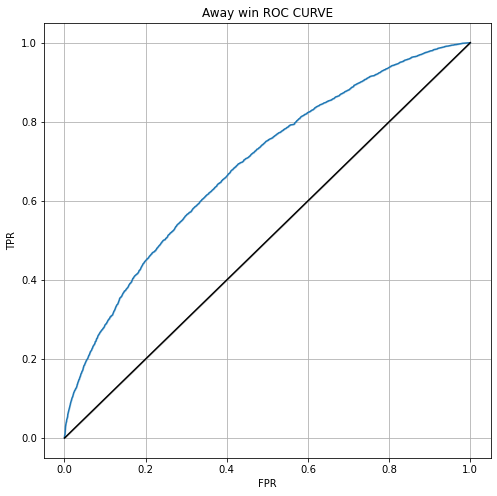

In [100]:
fig, ax = plt.subplots(figsize=(8, 8))
p1 = sns.lineplot(y = df_roc.TPR, x = df_roc.FPR, ax=ax)
p2 = sns.lineplot(y = df_roc.FPR, x = df_roc.FPR, color='k', ax=ax)
plt.title("Away win ROC CURVE")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid('both')

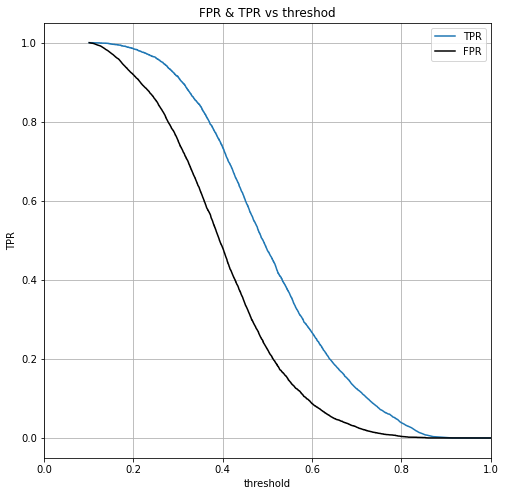

In [101]:
fig, ax = plt.subplots(figsize=(8, 8))
p1 = sns.lineplot(y = df_roc.TPR, x = df_roc.threshold, label = 'TPR', ax=ax)
p2 = sns.lineplot(y = df_roc.FPR, x = df_roc.threshold, label = 'FPR', color='k', ax=ax)
plt.title("FPR & TPR vs threshod")
plt.xlabel('threshold')
plt.xlim(0,1)
plt.legend()
plt.ylabel('TPR')
plt.grid('both')

**calibration plot**

In [107]:
prob_true, prob_pred = calibration_curve(y_holdout, lr_model.predict_proba(x_holdout_normalized)[:,1], n_bins=50, normalize = True)

''

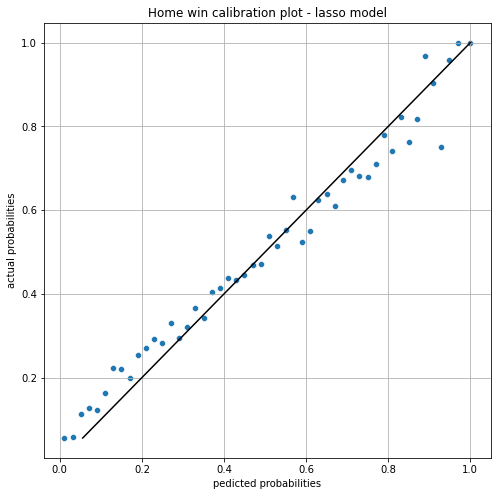

In [110]:
fig, ax = plt.subplots(figsize=(8, 8))
p1 = sns.scatterplot(y = prob_true, x = prob_pred, ax=ax)
p2 = sns.lineplot(y = prob_true, x = prob_true, color='k', ax=ax)
plt.title("Home win calibration plot - lasso model")
plt.xlabel('pedicted probabilities')
plt.ylabel('actual probabilities')
plt.grid('both')
;

#### statsmodels

In [114]:
import statsmodels.api as sm

In [112]:
df_t = df_train[['prob_home_win', 'prob_draw','prob_away_win']]

In [111]:
df_train.columns

Index(['match_id', 'season', 'div', 'odds_home_team_win', 'odds_draw',
       'odds_away_team_win', 'home_team_match_nr', 'home_team_goal_roll1_sum',
       'home_team_goal_roll2_sum', 'home_team_goal_roll3_sum',
       ...
       'home_team_relative_point_roll2_sum',
       'home_team_relative_point_roll3_sum',
       'home_team_relative_point_roll4_sum',
       'away_team_relative_point_roll1_sum',
       'away_team_relative_point_roll2_sum',
       'away_team_relative_point_roll3_sum',
       'away_team_relative_point_roll4_sum', 'prob_home_win', 'prob_draw',
       'prob_away_win'],
      dtype='object', length=178)

In [116]:
glm_binom = sm.GLM(df_train.home_win_flag, df_t, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          home_win_flag   No. Observations:                51327
Model:                            GLM   Df Residuals:                    51324
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32455.
Date:                Mon, 06 Mar 2023   Deviance:                       64909.
Time:                        16:59:57   Pearson chi2:                 5.12e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
prob_home_win     2.2741      0.067     34.029

In [117]:
res.params

prob_home_win    2.274110
prob_draw       -2.064079
prob_away_win   -2.296160
dtype: float64

In [119]:
y_sm_pred = res.predict()

In [121]:
roc_auc_score(df_train.home_win_flag, y_sm_pred)

0.6799000127301664

In [122]:
prob_true, prob_pred = calibration_curve(df_train.home_win_flag, y_sm_pred, n_bins=50, normalize = True)

''

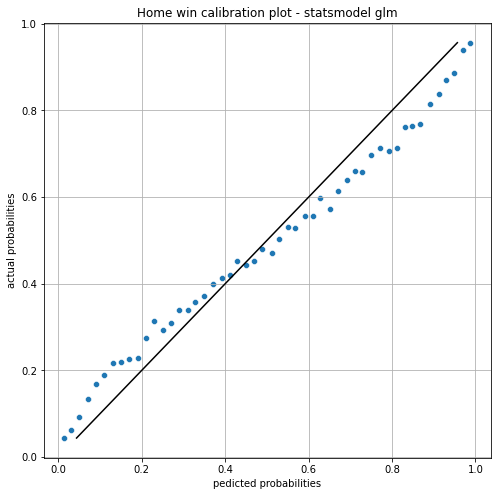

In [124]:
fig, ax = plt.subplots(figsize=(8, 8))
p1 = sns.scatterplot(y = prob_true, x = prob_pred, ax=ax)
p2 = sns.lineplot(y = prob_true, x = prob_true, color='k', ax=ax)
plt.title("Home win calibration plot - statsmodel glm")
plt.xlabel('pedicted probabilities')
plt.ylabel('actual probabilities')
plt.grid('both')
;

In [1]:
l = ['a', 'b', 'c']

In [3]:
list(set(l) - set(['c', 'd']))

['a', 'b']